# Core Lithology Classification Project
This notebook walks through the integration of synthetic core image data and geochemistry to classify lithologies using machine learning and deep learning techniques.

## 1. Load Data

In [2]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

df = pd.read_csv('geochemistry.csv')
df.head()

,SampleID,Ni_ppm,Cu_ppm,Fe_pct,S_pct,Lithology
0,Core_0,3248.357077,129.231463,8.536681,1.251301,Felsic
1,Core_1,2930.867849,178.967734,8.841177,1.331946,Felsic
2,Core_2,3323.844269,182.864274,9.624577,1.724188,Mafic
3,Core_3,3761.514928,159.886137,9.580703,1.683111,Mafic
4,Core_4,2882.923313,191.935714,5.933496,1.493730,Felsic


## 2. Visualize Core Images

Text(0.5, 1.0, 'Felsic')

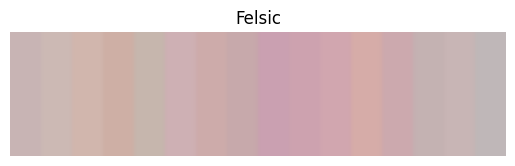

In [3]:
img_path = 'sample_core_images/' + df['SampleID'].iloc[0] + '.png'
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(df['Lithology'].iloc[0])

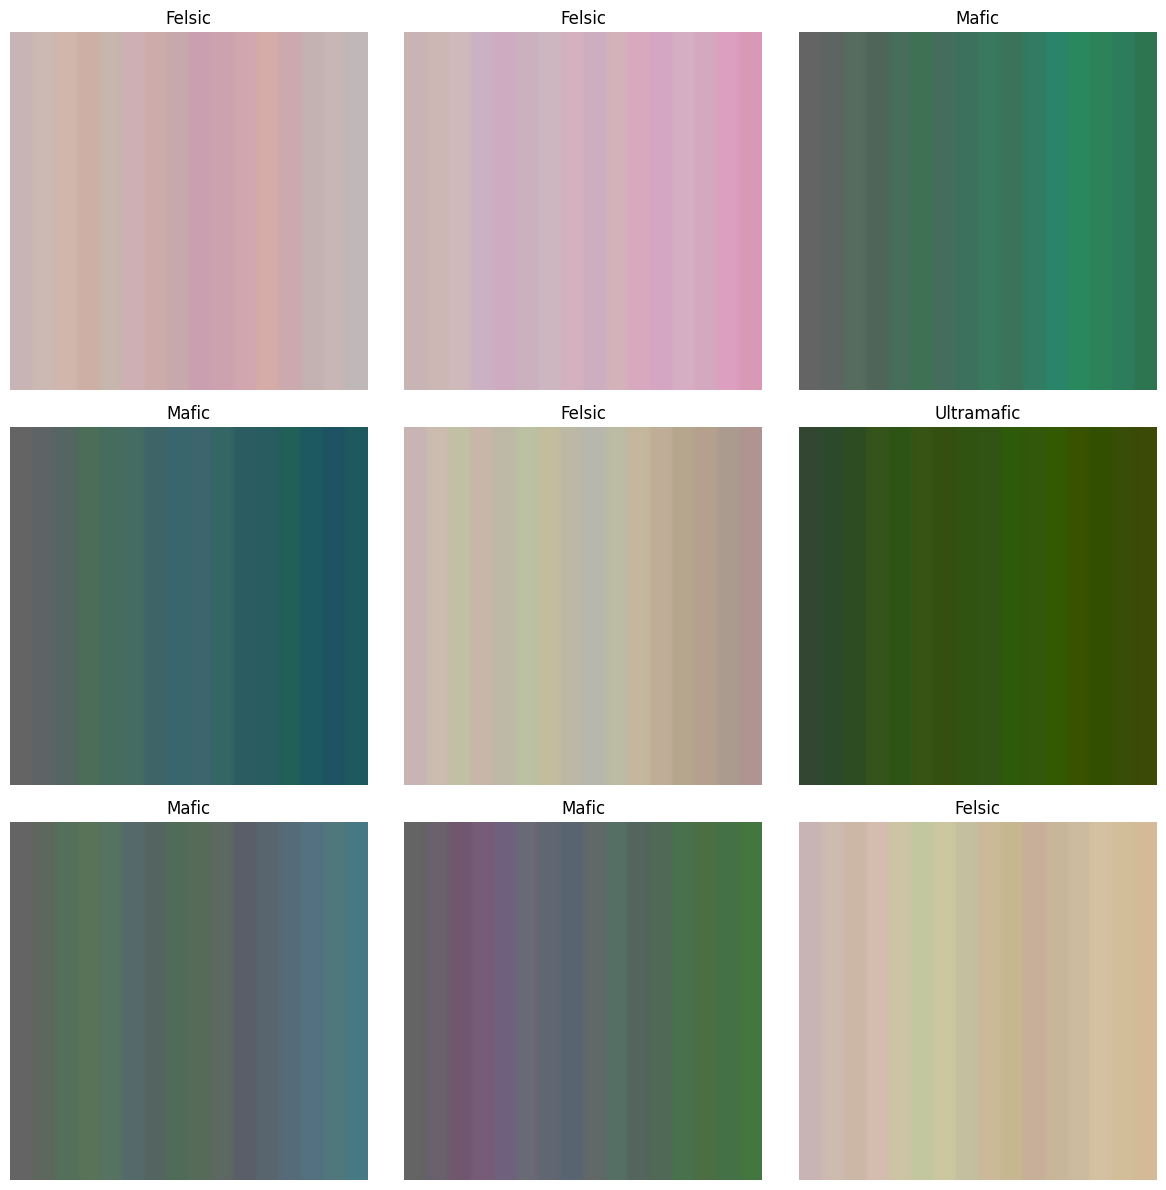

In [4]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Sample size to display
num_images = 9
img_size = (128, 128)

# Select the first `num_images` from your dataframe
sample_rows = df.head(num_images)

# Create plot grid
plt.figure(figsize=(12, 12))

for i, row in enumerate(sample_rows.itertuples()):
    sample_id = row.SampleID
    label = row.Lithology
    img_path = os.path.join('sample_core_images', f'{sample_id}.png')
    
    if os.path.exists(img_path):
        img = Image.open(img_path).resize(img_size)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(label)
    else:
        print(f"Image not found: {img_path}")

plt.tight_layout()
plt.show()

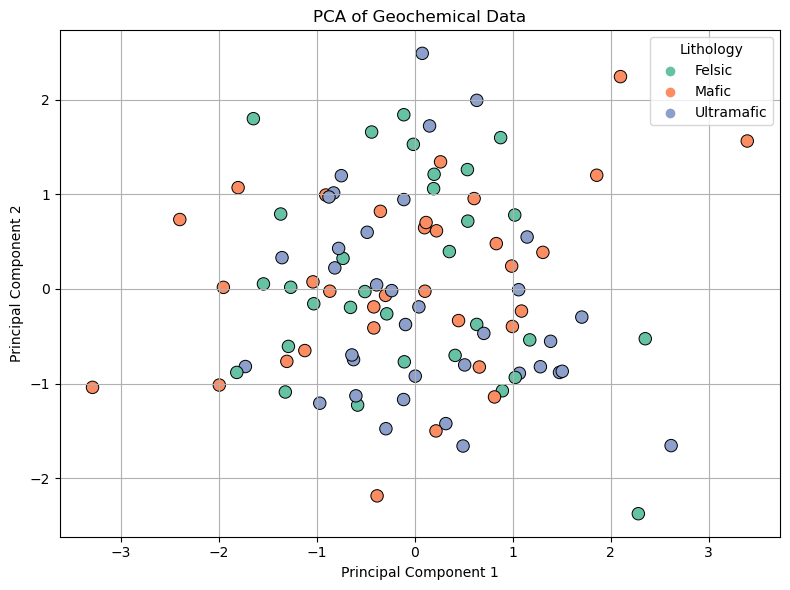

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load geochemical data
geochem_path = 'geochemistry.csv'
df = pd.read_csv(geochem_path)

# Optional: Encode Lithology numerically
lithology_mapping = {"Mafic": 0, "Ultramafic": 1, "Felsic": 2}
df["Lithology_Code"] = df["Lithology"].map(lithology_mapping)

# Select geochemical features
features = ["Ni_ppm", "Cu_ppm", "Fe_pct", "S_pct"]
X = df[features].values
X_scaled = StandardScaler().fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
df["PC1"] = components[:, 0]
df["PC2"] = components[:, 1]

# Plot PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="Lithology",
    palette="Set2",
    data=df,
    s=80,
    edgecolor='black'
)
plt.title("PCA of Geochemical Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# 📁 File: src/image_features.py
# Description: Extracts color histogram and GLCM texture features from core images

import os
import numpy as np
import cv2
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.io import imread


def extract_features_from_image(img_path):
    img = imread(img_path)
    gray = rgb2gray(img)
    gray_uint8 = (gray * 255).astype('uint8')

    # GLCM texture features
    glcm = graycomatrix(gray_uint8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    entropy = -np.sum(glcm * np.log2(glcm + 1e-10))

    # Color histogram features
    hist_r = np.histogram(img[:, :, 0], bins=16, range=(0, 255))[0]
    hist_g = np.histogram(img[:, :, 1], bins=16, range=(0, 255))[0]
    hist_b = np.histogram(img[:, :, 2], bins=16, range=(0, 255))[0]

    hist_features = np.concatenate([hist_r, hist_g, hist_b])
    hist_features = hist_features / np.sum(hist_features)  # Normalize

    return {
        'contrast': contrast,
        'homogeneity': homogeneity,
        'entropy': entropy,
        **{f'hist_{i}': val for i, val in enumerate(hist_features)}
    }


def process_all_images(image_dir):
    feature_list = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):
            sample_id = filename.replace(".png", "")
            features = extract_features_from_image(os.path.join(image_dir, filename))
            features['SampleID'] = sample_id
            feature_list.append(features)
    return pd.DataFrame(feature_list)


if __name__ == "__main__":
    image_dir = "sample_core_images"
    output_csv = "data/image_features.csv"
    df = process_all_images(image_dir)
    df.to_csv(output_csv, index=False)
    print(f"Extracted features saved to {output_csv}")

Extracted features saved to data/image_features.csv


In [1]:
import sys
print(sys.executable)
# C:\Users\yourname\anaconda3\envs\tf_env\python.exe
# C:\Users\yourname\anaconda3\envs\python.exe  (THIS IS BASE ENVIROMENT)

C:\Users\samer\anaconda3\envs\tf_env\python.exe


In [2]:
import tensorflow as tf
print(tf.__version__)

2.19.0


C:\Users\samer\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 822,467 (3.14 MB)

 Trainable params: 822,467 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 378ms/step - accuracy: 0.3375 - loss: 1.0479 - val_accuracy: 0.3000 - val_loss: 1.0237
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.5000 - loss: 0.9077 - val_accuracy: 0.6500 - val_loss: 0.8383
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.6750 - loss: 0.7499 - val_accuracy: 0.7500 - val_loss: 0.6469
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.7750 - loss: 0.5568 - val_accuracy: 0.8000 - val_loss: 0.4713
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.8875 - loss: 0.4025 - val_accuracy: 0.8000 - val_loss: 0.3861
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.8750 - loss: 0.3114 - val_accuracy: 0.9500 - val_loss: 0.2244
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 0.1401 - val_accuracy: 0.9500 - val_loss: 0.1551
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 0.1036 - val_accuracy: 1.0000 - val_loss:

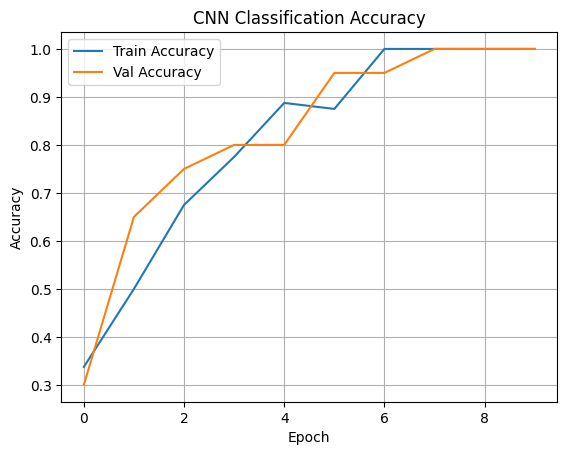

In [6]:
# 📁 File: notebooks/4_cnn_classifier.ipynb
# Description: CNN classifier for core images using TensorFlow/Keras

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image

# Load image labels
labels_df = pd.read_csv('data/geochemistry.csv')
labels_df.set_index('SampleID', inplace=True)

# Load and resize images
image_dir = 'sample_core_images'
X, y = [], []
img_size = (64, 64)

for filename in os.listdir(image_dir):
    if filename.endswith('.png'):
        sample_id = filename.replace('.png', '')
        if sample_id not in labels_df.index:
            print(f"⚠️ Missing SampleID in geochemistry.csv: {sample_id}")
            continue  # Skip this image if label is missing
        label = labels_df.loc[sample_id]['Lithology']
        img = Image.open(os.path.join(image_dir, filename)).resize(img_size)
        X.append(np.array(img) / 255.0)
        y.append(label)

X = np.array(X)
y = np.array(y)

# Encode labels
label_map = {"Mafic": 0, "Ultramafic": 1, "Felsic": 2}
y_encoded = np.array([label_map[label] for label in y])
y_cat = tf.keras.utils.to_categorical(y_encoded, num_classes=3)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=16)

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Classification Accuracy')
plt.grid(True)
plt.show()


Classification Report:

              precision    recall  f1-score   support

       Mafic       1.00      1.00      1.00         6
  Ultramafic       1.00      1.00      1.00         8
      Felsic       1.00      1.00      1.00         6

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



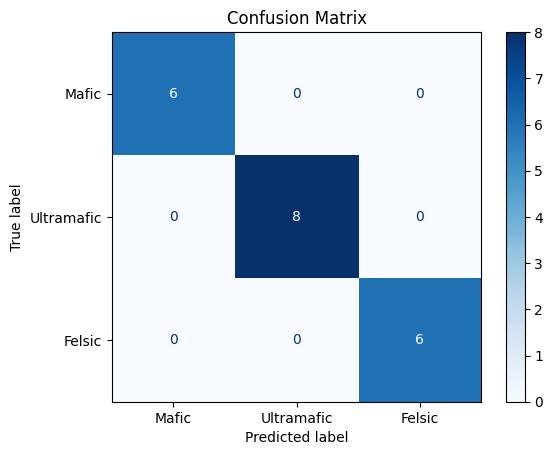

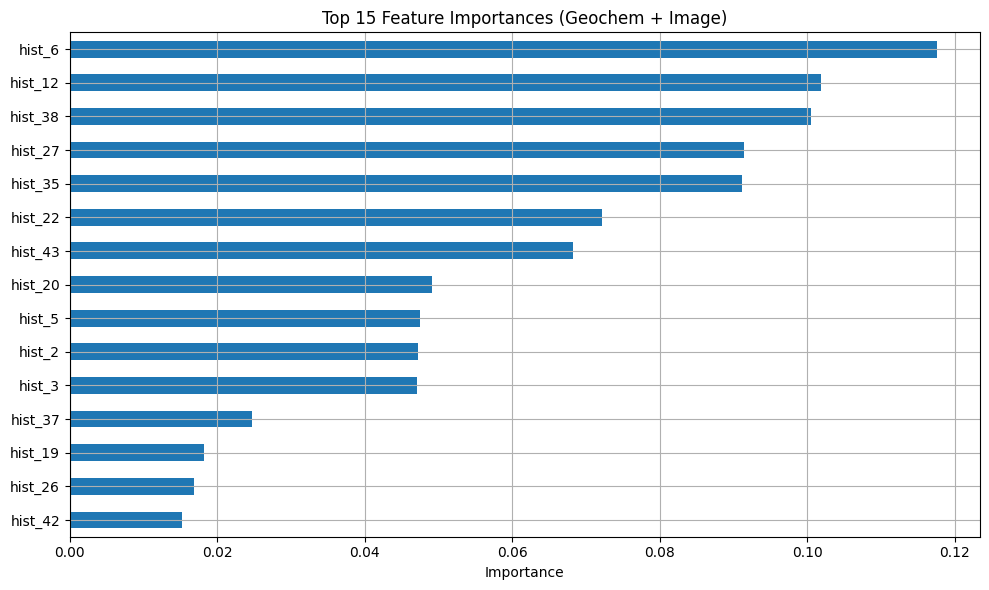

In [1]:
# 📁 File: notebooks/5_hybrid_model.ipynb
# Description: Combines geochemistry + image features for hybrid lithology classification

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Load geochemistry and image feature data
df_geo = pd.read_csv('data/geochemistry.csv')
df_img = pd.read_csv('data/image_features.csv')

# Merge datasets on SampleID
df_merged = pd.merge(df_geo, df_img, on='SampleID')

# Encode target labels
target_map = {"Mafic": 0, "Ultramafic": 1, "Felsic": 2}
df_merged["target"] = df_merged["Lithology"].map(target_map)

# Define input features
features = ["Ni_ppm", "Cu_ppm", "Fe_pct", "S_pct"] + [col for col in df_img.columns if col.startswith("hist_") or col in ["contrast", "homogeneity", "entropy"]]
X = df_merged[features]
y = df_merged["target"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=target_map.keys()))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=target_map.keys(), cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Feature importance
importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
importances.sort_values(ascending=False).head(15).plot(kind='barh')
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances (Geochem + Image)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

